In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from py_vollib.ref_python.black_scholes_merton import black_scholes_merton

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# get historical daily price for SPY
symbol = 'SPY'

tick = yf.Ticker(symbol)
history = tick.history(period="max")
df = pd.DataFrame()
df['close'] = history.Close
df['ret']= np.log(df.close).diff(1)
df['realized_vol'] = df.ret.rolling(21).std()*np.sqrt(252)*100
df['actual_ret']= df.close.pct_change(45)
df['ret_sd'] = df.actual_ret.rolling(45).std()
df['ret_mean'] = df.actual_ret.rolling(45).mean()

# compute some more params
# z = (x – μ) / σ

df['z_ret'] = (df.ret_mean-df.ret_mean.mean())/df.ret_mean.std()
df['z_vol'] = (df.realized_vol-df.realized_vol.mean())/df.realized_vol.std()

df = df.dropna()


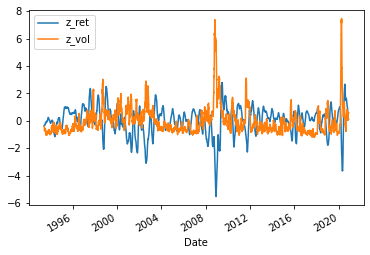

In [3]:
df[['z_ret','z_vol']].plot()

In [4]:
df

,close,ret,realized_vol,actual_ret,ret_sd,ret_mean,z_ret,z_vol
Date,,,,,,,,
1993-06-08,26.668728,-0.009044,11.793271,0.014174,0.012296,0.001213,-0.341829,-0.402515
1993-06-09,26.761911,0.003488,11.827997,0.012694,0.012282,0.001200,-0.342089,-0.399176
1993-06-10,26.780537,0.000696,11.750244,0.016265,0.012483,0.001488,-0.336511,-0.406651
1993-06-11,26.892370,0.004167,11.806925,0.016914,0.012686,0.001759,-0.331265,-0.401202
1993-06-14,26.855091,-0.001387,10.924108,0.016937,0.012808,0.002295,-0.320882,-0.486070
...,...,...,...,...,...,...,...,...
2020-11-16,362.570007,0.012405,22.257778,0.075523,0.034926,0.024430,0.107808,0.603474
2020-11-17,360.619995,-0.005393,21.535533,0.064361,0.034418,0.024073,0.100882,0.534042
2020-11-18,356.279999,-0.012108,22.111555,0.055741,0.034263,0.023925,0.098017,0.589417


In [128]:
import numpy as np
import pandas as pd
import yfinance as yf
from py_vollib.ref_python.black_scholes_merton import black_scholes_merton

class Portfolio:
    def __init__(self,open_date=None,initial_deposit=100000):
        self.open_date = open_date
        self.cash = initial_deposit
        self.history = [{'date':self.open_date,'cash':self.cash,'multiplier':0}]
        self.positions = {}
        self.closed_positions = []
    def manage_positions(self,row):
        todelete = []
        m=0
        if len(self.positions)==0:
            # open position if there are no positions
            strategy = IronCondor()
            if strategy.open_confidence(row) > 0.5:
                strategy.open_position(row,self)
                self.positions[strategy.name]=strategy
                m = strategy.multiplier
        else:
            # manage existing
            for k,v in self.positions.items():
                action = v.manage_position(row)
                if action == 'close_position':
                    v.close_position(row,self)
                    todelete.append(k)
                m = v.multiplier
            for k in todelete:
                self.closed_positions.append(self.positions.pop(k))

        mytoday = {'date':row.index[-1],'cash':self.cash,'m':m}
        self.history.append(mytoday)

class Strategy:
    def __init__(self):
        self.slippage = 0.01
        self.entry_row = None
        self.exit_row = None
        self.entry_price = None
        self.exit_price = None
        self.multiplier = 1
    def open_confidence(self,row):
        raise NotImplementedError()
    def compute_price(self,row):
        raise NotImplementedError()
    def manage_position(self,row):
        raise NotImplementedError()
    def open_position(self,row,portfolio):
        # positive value is credit
        slippage = (1-self.slippage)
        self.entry_price = slippage*self.compute_price(row)
        # 1 percent of cash value
        m = int((0.01*portfolio.cash)/self.entry_price)
        if m > 1:
            self.multiplier = m
        else:
            self.multiplier = 1
        portfolio.cash+=1*self.multiplier*self.entry_price
        self.entry_row = row
        
    def close_position(self,row,portfolio):
        # negative value is debit.
        slippage = (1+self.slippage)
        self.exit_price = slippage*self.compute_price(row)
        portfolio.cash+=-1*self.multiplier*self.exit_price
        self.exit_row = row
        
class ShortStrangle(Strategy):
    name = 'ShortStrangle'
    def open_confidence(self,row):
        return 1
    def _get_dte(self,row):
        if self.entry_row is None:
            # assuming you always can find a 45 dte contract
            dte = 45
        else:
            dte = 45-(row.index[-1]-self.entry_row.index[-1]).days
        return 1 if dte<=1 else dte
    
    def compute_price(self,row):
        dte = self._get_dte(row)
        time_to_expiry_years = dte/365
        
        underlying_price = row.close.values[-1]
        ret_mean = row.ret_mean.values[-1]
        ret_sd = row.ret_sd.values[-1]
        sigma = row.realized_vol.values[-1]/100
        
        p1sd_strike = underlying_price*(1+ret_mean+1*ret_sd)
        m1sd_strike = underlying_price*(1+ret_mean-1*ret_sd)
        
        S = underlying_price
        K = p1sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        call_1sd_price = black_scholes_merton('c', S, K, t, r, sigma, q)
        
        S = underlying_price
        K = m1sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        put_1sd_price = black_scholes_merton('p', S, K, t, r, sigma, q)

        return call_1sd_price+put_1sd_price
            
    def manage_position(self,row):
        dte = self._get_dte(row)
        slippage = (1+self.slippage)
        current_price = slippage*self.compute_price(row)
        myreturn = (self.entry_price-current_price)/self.entry_price
        # exit at 25% profit
        if myreturn > 0.25:
            return 'close_position'
        if dte < 21:
            return 'close_position'
        if myreturn < -1.0:
            return 'close_position'
        return 'maintain_position'

# http://www.cboe.com/index/dashboard/cndr#cndr-performance        
class IronCondor(Strategy):
    name = 'IronCondor'
    def open_confidence(self,row):
        return 1
    def _get_dte(self,row):
        if self.entry_row is None:
            # assuming you always can find a 45 dte contract
            dte = 45
        else:
            dte = 45-(row.index[-1]-self.entry_row.index[-1]).days
        return 1 if dte<=1 else dte
    
    def compute_price(self,row):
        dte = self._get_dte(row)
        time_to_expiry_years = dte/365
        
        underlying_price = row.close.values[-1]
        ret_mean = row.ret_mean.values[-1]
        ret_sd = row.ret_sd.values[-1]
        sigma = row.realized_vol.values[-1]/100
        
        # http://www.cboe.com/index/dashboard/cndr#cndr-performance

        p1sd_strike = underlying_price*(1+1*ret_sd)
        m1sd_strike = underlying_price*(1+1*ret_sd)
        
        p2sd_strike = underlying_price*(1-2*ret_sd)
        m2sd_strike = underlying_price*(1-2*ret_sd) #+ret_mean

        S = underlying_price
        K = p1sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        call_1sd_price = black_scholes_merton('c', S, K, t, r, sigma, q)
        
        S = underlying_price
        K = m1sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        put_1sd_price = black_scholes_merton('p', S, K, t, r, sigma, q)

        S = underlying_price
        K = p2sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        call_2sd_price = black_scholes_merton('c', S, K, t, r, sigma, q)
        
        S = underlying_price
        K = m2sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        put_2sd_price = black_scholes_merton('p', S, K, t, r, sigma, q)
        
        return call_1sd_price+put_1sd_price-call_2sd_price-put_2sd_price
    
    def manage_position(self,row):
        dte = self._get_dte(row)
        slippage = (1+self.slippage)
        current_price = slippage*self.compute_price(row)
        myreturn = (self.entry_price-current_price)/self.entry_price

        if dte < 5:
            return 'close_position'
        if myreturn > .25:
            return 'close_position'
        if myreturn < -.5:
            return 'close_position'
        return 'maintain_position'


In [129]:
# back test
mydf = df.iloc[-252*10:].copy()
#mydf = df.iloc[:].copy()
myportfolio = Portfolio(open_date=mydf.index[0])
def myfunc(ser):
    rows = df.loc[ser.index]
    row = rows.iloc[-1:]
    myportfolio.manage_positions(row)
    return 0

rol = mydf.close.rolling(window=2)
_=rol.apply(myfunc, raw=False)

pdf = pd.DataFrame(myportfolio.history)
pdf.index = pdf.date
del pdf['date']

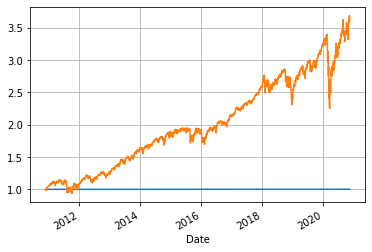

In [130]:
(pdf.cash/pdf.cash.iloc[0]).plot()
(mydf.close/mydf.close.iloc[0]).plot()
plt.grid(True)

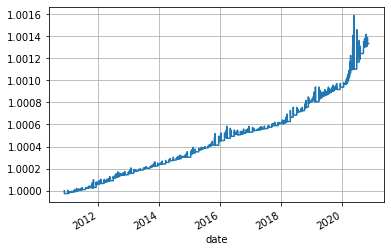

In [131]:
(pdf.cash/pdf.cash.iloc[0]).plot()
plt.grid(True)

![cboe-cndr](static/cboe_cndr.png)

```
Cboe S&P 500 Iron Condor Index (CNDR)

The Cboe S&P 500 Condor IndexSM  (CNDR) is inspired by the condor option strategy. The objective of a condor option spread is to mine "out-of-the-money" option volatility premium with limited risk.  A generic condor option spread is short an out-of-the-money  straddle and long further out-of-the money call and put that bound the risk of the straddle. 

The CNDR index follows this strategy and sells a butterfly spread of the S&P 500® one-month options (SPX options).  More precisely,  it tracks the value of a hypothetical portfolio that overlays a butterfly spread of SPX  options over one-month Treasury bills . The short SPX straddle is at-the-money and the long SPX call and put are 5% out-of-the-money.  to guarantee solvency, the Treasury bills cover ten times the maximum loss of the short butterfly spread. 

The BFLY portfolio is rebalanced monthly, usually  at 11 am ET every third Friday after the options in the butterfly spread expire. A new SPX butterfly spread is then sold. 

The CNDR   portfolio is rebalanced monthly after  the expiration of SPX options, typically 11 am ET every  third Friday. New SPX  options are then bought and sold.

excerpt from 
http://www.cboe.com/index/dashboard/cndr#cndr-performance
```

##### ** until above backtest pnl performs like CBOE CNDR index, do not trust backtest one bit**
